# CSE 152A Winter 2023 – Assignment 2

- Assignment Published On: **Tuesday, October 24, 2023**

- Due On: **Saturday, November 4 11:59 PM (Pacific Time)**


## Instructions

Please answer the questions below using Python in the attached Jupyter notebook and follow the guidelines below:

- This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy posted on lecture slides.

- All the solutions must be written in this Jupyter notebook.

- After finishing the assignment in the notebook, please export the notebook as a PDF and submit both the notebook and the PDF (i.e. the `.ipynb` and the `.pdf` files) on Gradescope.

- You may use basic algebra packages (e.g. `NumPy`, `SciPy`, etc) but you are not allowed to use open source codes that directly solve the problems. Feel free to ask the instructor and the teaching assistants if you are unsure about the packages to use.

- It is highly recommended that you begin working on this assignment early.

- Make sure that you read hints for questions (wherever given).

**Late Policy:** Assignments submitted late will receive a 25% grade reduction for each 12 hours late (that is, 50% per day).


In [1]:
# Setup
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
import cv2
import math
import pickle

## Problem 1: Edge & Corner Detection [23 pts]

### Problem 1.1: Edge Detection [8 pts]

In this problem, you will write a function to perform edge detection. The following steps need to be implemented.

- **Smoothing [2 pt]:** First, we need to smooth the images to prevent noise from being considered edges. For this problem, use a 9x9 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

- **Gradient Computation [3+3 pts]:** After you have finished smoothing, find the image gradient in the horizontal and vertical directions. Compute the gradient magnitude image as $|G| = \sqrt{G_x^2 + G_y^2}$ and gradient direction as $tan^{-1}(G_y/G_x)$.

Compute the images after each step. Show each of the intermediate steps and label your images accordingly.

In total, there should be four output images (original, smoothed, gradient magnitude, gradient direction).

**For this question, use the image `geisel.jpeg`.**


### !! Hint !!

$G_x$ and $G_y$ are the image gradients along x and y directions respectively. To get the image gradients, it is recommended that you use convolutions(similar to the approach that you used in HW1). Learn about them here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Convolution can also be used to smooth the image.

For gradient direction, try utilizing the arctan2 function to obtain the angle:
https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html


Original:


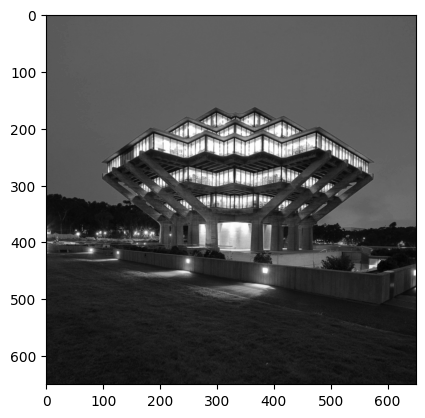

Smoothed:


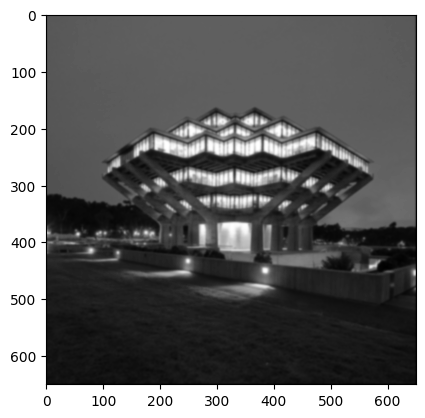

Gradient magnitude:


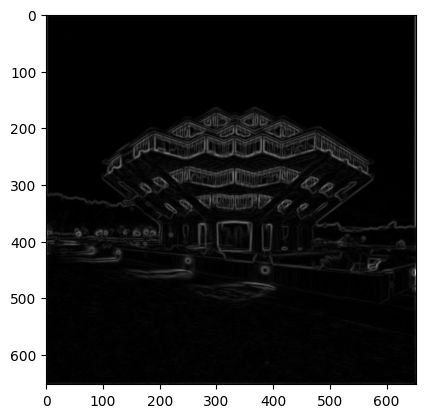

Gradient direction:


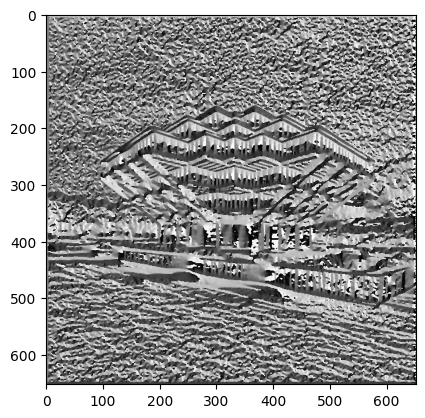

In [2]:
import numpy as np
from skimage import io
from collections import defaultdict
from scipy.signal import convolve
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian2d(filter_size=9, sig=1.0):
    """
    Creates 2D Gaussian kernel with side length `filter_size` and a sigma of `sig`.
    Source: https://stackoverflow.com/a/43346070
    """
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)


def smooth(image):
    """ 
    Args:
        image: input image (h, w)
        
    Returns:
        smooth_image: smoothened version of the input image (h, w) 
    """
        
    ### YOUR CODE HERE
    kernel = gaussian2d(9, 1.4)
    smooth_image = convolve(image, kernel, mode='same')
    ### END YOUR CODE
    
    return smooth_image

def gradient(image):
    """ 
    Args:
        image: input image (h, w)

    Returns:
        g_mag: gradient magnitude (h, w)
        g_theta: gradient direction (h, w)
    """

    ### YOUR CODE HERE
    kernel_x = np.array([[0, 0, 0], [1, 0, -1], [0, 0, 0]]) * 0.5
    kernel_y = np.array([[0, 1, 0], [0, 0, 0], [0, -1, 0]]) * 0.5

    gx = convolve(image, kernel_x)
    gy = convolve(image, kernel_y)
    
    g_mag = np.sqrt(gx**2 + gy**2)
    
    g_theta = np.arctan2(gy,gx)
    ### END YOUR CODE
    return g_mag, g_theta

def edge_detect(image):
    """Perform edge detection on the image."""
    smoothed = smooth(image)
    g_mag, g_theta = gradient(smoothed)
    return smoothed, g_mag, g_theta

# Load image in grayscale
image = io.imread('geisel.jpeg', as_gray=True)
smoothed, g_mag, g_theta = edge_detect(image)

print('Original:')
plt.imshow(image, cmap='gray')
plt.show()

print('Smoothed:')
plt.imshow(smoothed, cmap='gray')
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag, cmap='gray')
plt.show()

print('Gradient direction:')
plt.imshow(g_theta, cmap='gray')
plt.show()

### Problem 1.2: Corner Detection [15 pts]

Next, you will implement a corner detector to detect photo-identifiable features in the image.

This should be done according to the easier method of looking at regions with significant value of the minimum eigenvalue. You should fill in the function <code>corner_detect</code> with inputs <code>image, nCorners, smoothSTD, windowSize</code>, where smoothSTD is the standard deviation of the smoothing kernel and windowSize is the window size for Gaussian smoothing, corner detection and non-maximum suppression. Instead of using a hard threshold, return the nCorners strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. Your function should also return the matrix of minimum eigen values that you computed.

For each image, detect 100 corners with a Gaussian standard deviation of 2.0 and a window size of 13. Display the corners using the show_corners_result function and plot the minimum eigen value images using the show_eigen_images function.

**For this question, we will use images `almond0.jpg` and `almond1.jpg`.**

### !! Hint !!

A window in an image is usually represented by its center pixel. So in the example below, the window size = 3, image shape = 6 x 6 and the shown window correponds to the pixel location (1,1) or i5. Think about how you need to iterate over the image dimensions to get the different windows of an image. **Be wary of the image boundaries**.

<div>
<img src="attachment:Screenshot%202023-02-03%20at%2011.48.02%20AM-2.png" width="300"/>
</div>


In [3]:
def rgb2gray(rgb):
    """Convert rgb image to grayscale."""
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [78]:
from skimage.feature import corner_peaks


def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for Gaussian smoothing kernel, corner detector, and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).
        The minor eigen value image having the same shape as the image
    """

    corners = np.zeros((nCorners, 2))
    minor_eig_image = np.zeros_like(image)

    # Calcul du noyau Gaussien pour le lissage
    kernel = gaussian2d(windowSize, smoothSTD)

    # Opérateurs Sobel pour calculer les gradients
    kernel_x = np.array([[1, 0, -1]]) * 0.5
    kernel_y = np.array([[1], [0], [-1]]) * 0.5

    smooth = convolve(image, kernel, mode="same")

    # Itérer sur l'image pour détecter les coins
    for i in range(windowSize // 2, smooth.shape[0] - windowSize // 2):
        for j in range(windowSize // 2, smooth.shape[1] - windowSize // 2):
            window = smooth[
                i - windowSize // 2 : i + windowSize // 2 + 1,
                j - windowSize // 2 : j + windowSize // 2 + 1,
            ]

            # Extraire les gradients
            Ix = convolve(window, kernel_x, mode="same")
            Iy = convolve(window, kernel_y, mode="same")

            # Calculer le tenseur de structure
            C = np.array(
                [[np.sum(Ix**2), np.sum(Ix * Iy)], [np.sum(Ix * Iy), np.sum(Iy**2)]]
            )

            # Calculer les valeurs propres
            eigenvalues = np.linalg.eigvals(C)

            # Stocker la plus petite valeur propre dans minor_eig_image
            minor_eig_image[i, j] = min(eigenvalues)

    corners = corner_peaks(minor_eig_image, num_peaks=nCorners)
    
    return corners, minor_eig_image

In [86]:
def show_eigen_images(imgs):
    print("Minor Eigen value images")
    fig = plt.figure(figsize=(16, 16))
    # Plot image 1
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0], cmap="gray")
    plt.title("almond 1")

    # Plot image 2
    plt.subplot(1, 2, 2)
    plt.imshow(imgs[1], cmap="gray")
    plt.title("almond 2")

    plt.show()


def show_corners_result(imgs, corners):
    print("Detected Corners")
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(imgs[0], cmap="gray")
    axes[0].scatter(
        corners[0][:, 1], corners[0][:, 0], s=35, edgecolors="r", facecolors="none"
    )
    axes[0].set_title("Image 1")

    axes[1].imshow(imgs[1], cmap="gray")
    axes[1].scatter(
        corners[1][:, 1], corners[1][:, 0], s=35, edgecolors="r", facecolors="none"
    )
    axes[1].set_title("Image 2")

    plt.show()

In [92]:
# detect corners on the two provided images
# adjust your corner detection parameters here
nCorners = 100
smoothSTD = 2
windowSize = 13

# read images and detect corners on images
imgs = []
eig_imgs = []
corners = []
for i in range(2):
    img = io.imread("almond" + str(i) + ".jpg")
    imgs.append(rgb2gray(img))
    corners_vals, minor_eig_image = corner_detect(
        imgs[-1], nCorners, smoothSTD, windowSize
    )
    eig_imgs.append(minor_eig_image)
    corners.append(corners_vals)

Minor Eigen value images


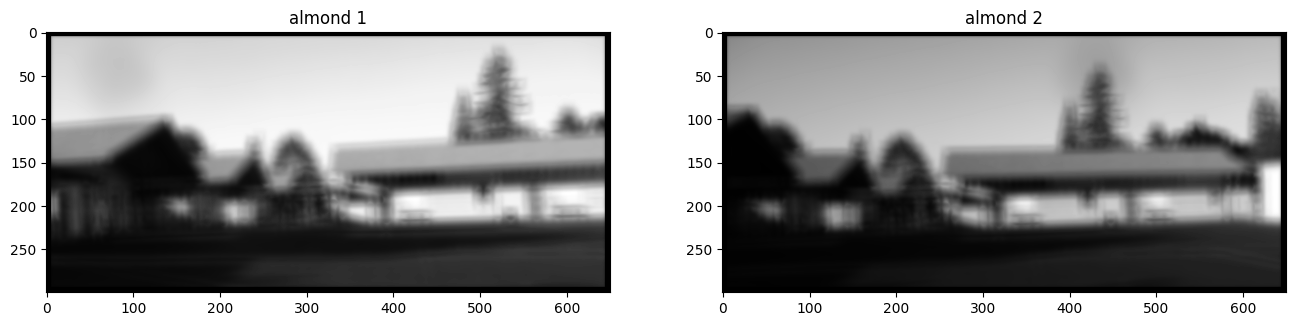

Detected Corners


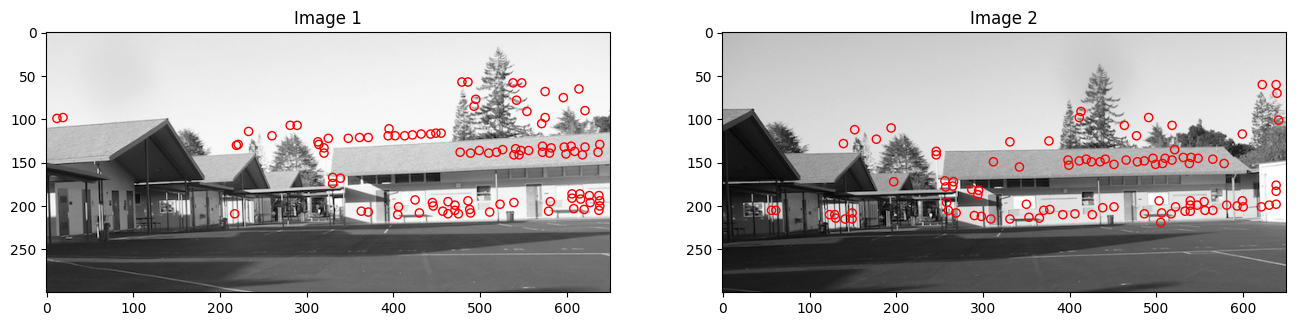

Detected Corners


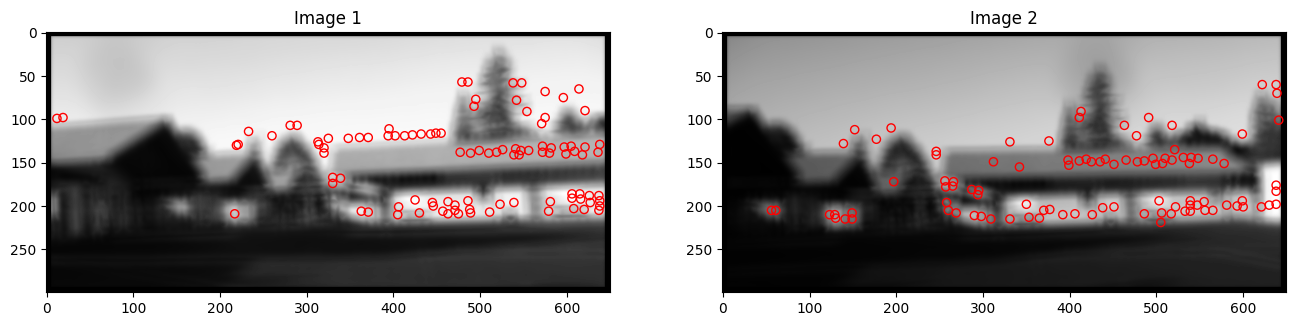

In [93]:
show_eigen_images(eig_imgs)
show_corners_result(imgs, corners)
show_corners_result(eig_imgs, corners)

## Problem 2: Theory [20 points]

### Problem 2.1: Epipolar Geometry [10 points]

Consider two cameras whose image planes are the z=2 plane, and whose focal points are at (-6, 0, 0) and (6, 0, 0). See Fig 1.1 below. We'll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-6, 0, 2) in world coordinates, while if (u, v) = (0, 0) this is the point (6, 0, 2).

![fig 1.1](fig/fig1.png)

Suppose the point (x, y) = (3, 3) is matched to the point (u, v) = (2, 3). What is the 3D location of this point?

### !! Hint !!

Think about how to convert the points (x, y) and (u, v) in the world coordinates. How would you use them and the camera centers in the world coordinates to get the 3D location of the point?


### Problem 2.2: The Epipolar Constraint [5 points]

Suppose two cameras fixate on a point $P$ in space such that their principal axes intersect at that point. (See the fig. 1.2 below.) Show that if the image coordinates are normalized so that the coordinate origin (0, 0) coincides with the principal point, then the $F_{33}$ element of the fundamental matrix is zero.

![fig 1.2](fig/ec_diagram.png)

In the figure, $C1$ and $C2$ are the optical centers. The principal axes intersect at point $P$.

### !! Hint !!

You will be required to convert the points into homogeneous coordinates.


### Problem 2.3: Essential Matrix [5 points]

Suppose a stereo rig is formed of two cameras: the rotation matrix and translation vector are given to you. Please write down the essential matrix. Also, compute the rank of the essential matrix using SVD, i.e., the number of nonzero singular values. (Note that if you get a singular value $s$ of a very small number in your calculation, e.g., $s<=1e-15$, you can treat it as zero singular value).

$$
R=
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} & 0 \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

$$
t=
\begin{bmatrix}
2 \\ 5 \\1
\end{bmatrix}
$$

### !! Hint !!

You may find the following implementation of SVD useful: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html


## Problem 3: SSD (Sum Squared Distance) and NCC (Normalized Cross-Correlation) Matching [21 points]

In this part, you have to write two functions <code>ssdMatch</code> and <code>nccMatch</code> that implement the computation of the matching score for two given windows with SSD and NCC metrics respectively.

### Problem 3.1: SSD (Sum Squared Distance) Matching [5 points]

Complete the function <code>ssdMatch</code>:  
SSD = $\sum_{x,y}|W_1(x,y)-W_2(x,y)|^2$


In [94]:
def ssdMatch(img1, img2, c1, c2, R):
    """Compute SSD given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        SSD matching score for two input windows (a scalar value).

    """
    ### YOUR CODE HERE

    ### END YOUR CODE

    return matching_score

In [95]:
# Here is the code for you to test your implementation
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print(ssdMatch(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 20
print(ssdMatch(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 30
print(ssdMatch(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 46

NameError: name 'matching_score' is not defined

### Problem 3.2: NCC (Normalized Cross-Correlation) Matching [8 points]

Complete the function <code>nccMatch</code>:
NCC = $\sum_{x,y}\tilde{W_1} (x,y)\cdot \tilde{W_2} (x,y)$ where $\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{x,y}(W(x,y) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window and $\overline{W}$ is the mean pixel value in the window W.


In [ ]:
def nccMatch(img1, img2, c1, c2, R):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        NCC matching score for two input windows (a scalar value).

    """

    ### YOUR CODE HERE

    ### END YOUR CODE

    return matching_score

In [ ]:
# Here is the code for you to test your implementation
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print(nccMatch(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 0.8546
print(nccMatch(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 0.8457
print(nccMatch(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 0.6258

### Problem 3.3: Naive Matching [8 points]

Given the corner points detected and the NCC matching function, we are ready to start finding correspondences. One naive strategy is to try and find the best match between the two sets of corner points. Write a script that does this, namely, for each corner in image1, find the best match from the detected corners in image2 (or, if the NCC match score is too low, then return no match for that point).

Write a function <code>naive_matching</code> and call it as below. Examine your results for 20 detected corners in each image.


In [ ]:
def naive_matching(img1, img2, corners1, corners2, R, NCCth):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        R: NCC matching radius
        NCCth: NCC matching score threshold

    Returns:
        NCC matching returns a list of tuple (c1, c2),
        c1 is the 1x2 corner location in image 1,
        c2 is the 1x2 corner location in image 2.

    """

    ### YOUR CODE HERE

    ### END YOUR CODE

    return matching

In [ ]:
def rgb2gray(rgb):
    """Convert rgb image to grayscale."""
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


# detect corners on warrior and matrix sets
# you are free to modify code here, create your helper functions, etc.

nCorners = 20
smoothSTD = 1
windowSize = 17

# read images and detect corners on images

imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []

for i in range(2):
    img_mat = imageio.imread("p4/matrix/matrix" + str(i) + ".png")
    imgs_mat.append(rgb2gray(img_mat))
    img_war = imageio.imread("p4/warrior/warrior" + str(i) + ".png")
    imgs_war.append(rgb2gray(img_war))

In [ ]:
# match corners
crnsmatf = open("crns_mat.pkl", "rb")
crns_mat = pickle.load(crnsmatf)
crnswarf = open("crns_war.pkl", "rb")
crns_war = pickle.load(crnswarf)
R = 120
NCCth = 0.6  # put your threshold here
matching_mat = naive_matching(
    imgs_mat[0] / 255, imgs_mat[1] / 255, crns_mat[0], crns_mat[1], R, NCCth
)
matching_war = naive_matching(
    imgs_war[0] / 255, imgs_war[1] / 255, crns_war[0], crns_war[1], R, NCCth
)

In [ ]:
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(
        np.hstack((img1, img2)), cmap="gray"
    )  # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors="r", facecolors="none")
        plt.scatter(
            p2[0] + img1.shape[1], p2[1], s=35, edgecolors="r", facecolors="none"
        )
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig("dino_matching.png")
    plt.show()


print("Number of Corners:", nCorners)
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

## Problem 4: Epipolar Geometry [13 points]

As shown in Problem 2, the naive mathing algorithm is simple. The weakness of this method comes from the high matching complexity. In this problem, we will explore how to visualize epipolar geometry constraint in the form of epipolar lines. Although it is outside the scope of this assignment, we can further use this constraint to rectify the images to build a better matching algorithm.

### Problem 4.1: Fundamental matrix [10 points]

Complete the <code>compute_fundamental</code> function below using the 8-point algorithm described in lecture. Note that the normalization of the corner points is handled in the <code>fundamental_matrix</code> function. <br/>
Hint: When you try to find the non-trival solution to an linear equation system **Af=0**, you can use singular value decomposition (SVD) method:SVD(**A**)=USV<sup>T</sup>. And **f** is given by the singular vector corresponding to the smallest singular value, which is the last column of V.


In [ ]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import svd


def compute_fundamental(x1, x2):
    """Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the 8 point algorithm.

    Construct the A matrix according to lecture
    and solve the system of equations for the entries of the fundamental matrix.

    Returns:
    Fundamental Matrix (3x3)
    """

    ### YOUR CODE HERE

    ### END YOUR CODE

    # constrain F
    # make rank 2 by zeroing out last singular value
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    return F / F[2, 2]

In [ ]:
def fundamental_matrix(x1, x2):
    # Normalization of the corner points is handled here
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2], axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1, 0, -S1 * mean_1[0]], [0, S1, -S1 * mean_1[1]], [0, 0, 1]])
    x1 = np.dot(T1, x1)

    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2], axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2, 0, -S2 * mean_2[0]], [0, S2, -S2 * mean_2[1]], [0, 0, 1]])
    x2 = np.dot(T2, x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1, x2)

    # reverse normalization
    F = np.dot(T1.T, np.dot(F, T2))

    return F / F[2, 2]

In [ ]:
# Here is the code for you to test your implementation
cor1 = np.load("./p4/" + "dino" + "/cor1.npy")
cor2 = np.load("./p4/" + "dino" + "/cor2.npy")
print(fundamental_matrix(cor1, cor2))
# should print
# [[ 4.00502510e-07  3.09619039e-06 -2.86966053e-03]
# [-2.69900666e-06 -1.00972419e-08  6.70452915e-03]
# [ 1.37819769e-03 -7.29675791e-03  1.00000000e+00]]

### Problem 4.2: Plot Epipolar Lines [3 points]

_You do not need to code anything here. Run the cells below and look at your results_

Using this fundamental matrix, we can plot the epipolar lines in both images for each image pair. For this part, you just have to use the function <code>plot_epipolar_lines</code> and check for the correctness of <code>compute_fundamental</code> that you have already written in Q4.1). Show your result for matrix and warrior as exemplified by the figure below.

![Dino Epipolar](fig/dinoEpi1.png)
![Dino Epipolar](fig/dinoEpi2.png)


In [ ]:
def plot_epipolar_lines(img1, img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """

    assert cor1.shape[0] == 3
    assert cor2.shape[0] == 3
    assert cor1.shape == cor2.shape

    F = fundamental_matrix(cor1, cor2)

    # epipole in image 1 is the solution to F^T e = 0
    U, S, V = np.linalg.svd(F.T)
    e1 = V[-1]
    e1 /= e1[-1]

    # epipole in image 2 is the solution to Fe = 0
    U, S, V = np.linalg.svd(F)
    e2 = V[-1]
    e2 /= e2[-1]

    plot_epipoles = False

    # Plot epipolar lines in the first image
    # There is an epipolar line for each corner
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img1, cmap="gray")
    h, w = img1.shape[:2]
    for c2 in cor2.T:
        # epipolar line is (F * c2) dot (x, y, 1) = 0
        epi_line = np.dot(F, c2)
        a, b, c = epi_line  # ax + by + c = 0, y = -a/b * x - c/b
        x = np.arange(w)
        y = (-a / b) * x - (c / b)
        x = np.array([x[i] for i in range(x.size) if y[i] >= 0 and y[i] < h - 1])
        y = np.array([y[i] for i in range(y.size) if y[i] >= 0 and y[i] < h - 1])
        plt.plot(x, y, "b", zorder=1)

    plt.scatter(cor1[0], cor1[1], s=50, edgecolors="b", facecolors="r", zorder=2)

    if plot_epipoles:
        plt.scatter([e1[0]], [e1[1]], s=75, edgecolors="g", facecolors="y", zorder=3)
    plt.show()

    # Plot epipolar lines in the second image
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img2, cmap="gray")
    h, w = img2.shape[:2]

    for c1 in cor1.T:
        # epipolar line is (F^T * c1) dot (x, y, 1) = 0
        epi_line = np.dot(F.T, c1)
        a, b, c = epi_line
        x = np.arange(w)
        y = (-a / b) * x - (c / b)
        x = np.array([x[i] for i in range(x.size) if y[i] >= 0 and y[i] < h - 1])
        y = np.array([y[i] for i in range(y.size) if y[i] >= 0 and y[i] < h - 1])
        plt.plot(x, y, "b", zorder=1)

    plt.scatter(cor2[0], cor2[1], s=50, edgecolors="b", facecolors="r", zorder=2)

    if plot_epipoles:
        plt.scatter([e2[0]], [e2[1]], s=75, edgecolors="g", facecolors="y", zorder=3)
    plt.show()

In [ ]:
# replace images and corners with those of matrix and warrior
imgids = ["dino", "matrix", "warrior"]
for imgid in imgids:
    I1 = imageio.imread("./p4/" + imgid + "/" + imgid + "0.png")
    I2 = imageio.imread("./p4/" + imgid + "/" + imgid + "1.png")
    cor1 = np.load("./p4/" + imgid + "/cor1.npy")
    cor2 = np.load("./p4/" + imgid + "/cor2.npy")
    plot_epipolar_lines(I1, I2, cor1, cor2)